In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# import random

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
# from numpy.random import *
from numpy.random import *


In [3]:
iris = load_iris()
x, y = iris.data, iris.target

x_df = pd.DataFrame(x, columns=['sepal_length', 'sepal_width', 'petal_length','petal_width'])
x_df_1 = x_df.loc[:,['sepal_length', 'petal_length']]
y_df = pd.DataFrame(y, columns=['Species'])

# 結合
iris_df = pd.concat([x_df_1, y_df], axis=1)
# 二値分類のため、０の花を削除
df = iris_df.loc[(iris_df['Species'] == 1)|(iris_df['Species'] == 2)].reset_index(drop=True)

x_data = df.drop(["Species"], axis=1).to_numpy()
y_data = df["Species"].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)
# データ準備完了


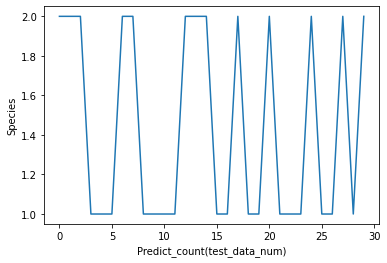

In [5]:
# 可視化

# 横軸に回数、縦軸に花の番号
# plt.plot(LGclf_proba)
plt.plot(LGclf_pred)
plt.xlabel('Predict_count(test_data_num)')
plt.ylabel("Species")
# plt.legend()
plt.show()

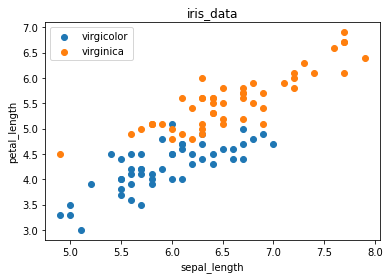

In [6]:
x_1 = df[df.Species==1].loc[:,"sepal_length"] # １の花のsepal length
x_2 = df[df.Species==2].loc[:, "sepal_length"]# ２の花のsepal length
# yの変数に２の花の特徴量
y_1 = df[df.Species==1].loc[:, "petal_length"]  #１の花のpetal_length
y_2 = df[df.Species==2].loc[:, "petal_length"]

plt.title("iris_data")
plt.scatter(x_1,y_1, label="virgicolor")
plt.scatter(x_2,y_2, label="virginica")
plt.xlabel('sepal_length')
plt.ylabel("petal_length")
plt.legend()
plt.show()

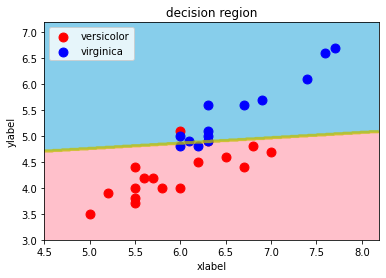

None


In [7]:
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
  
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()
print(decision_region(x_test, y_test, LGclf))

問題1　仮定関数

In [8]:
X = np.arange(100).reshape(20, 5)
a = np.ones(X.shape[0]).reshape(X.shape[0],1)

def _logistic_hypothesis(x):
    a = np.ones(x.shape[0]).reshape(x.shape[0], 1)
    x = np.hstack([a ,x])
    Theta = np.random.random_sample((1, x.shape[0]))
    answer = Theta @ x
    # シグモイド関数
    # マイナビの本の185p参照　-answerの意味用確認
    y_hat = 1 / 1 + np.exp(-answer)
    return y_hat

print(_logistic_hypothesis(X))

[[1.00010173 1.         1.         1.         1.         1.        ]]


問題2　最急降下法

問題3　推定

問題4　目的関数

全てクラス内でまとめて実装してます

In [9]:
class ScratchLogisticRegression:

    def __init__(self,num_iter,lr,bias,alpha,verbose,var=1):
        self.iter = num_iter #学習回数　
        self.lr = lr #学習率
        self.alpha = alpha #ラムダ
        self.bias = bias #傾き
        self.verbose = verbose
        # 損失関数を保存する（初期値として0）
        self.train_loss = np.zeros(self.iter+1)
        self.test_loss = np.zeros(self.iter+1)
        self.var=var
        
        
    # 問題2
    def fit(self, x, y, x_test=None, y_test=None):
        """
        線形回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。
        Parameters
        ----------
        x : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        x_test : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_test : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        #　theta_listを0配列に初期化する（行:学習回数分、列はxの列に＋1
        self.theta_list = np.zeros((self.iter+1,x.shape[1]+1))
        # 問題1の仮定関数を呼び出す
        self._logistic_hypothesis(x)
        y_hat = self._logistic_hypothesis(x)

        # ①********
        # 誤差の初期値としてcalc_errorの戻り値(推定値と実測値の誤差）を用意
        init_error = self.calc_error(x,y)
        # loss関数の0番目
        self.train_loss[0] = np.sum(init_error**2) /(2 * x.shape[0])

        # x_testも入力した場合
        if x_test is True: #x_test is Trueにする
            # テスト用の学習データも損失を保存しておく
            # ★calc_errorの引数にテスト用データを入れて、初期化変数に保存しておく
            # init_error= self.calc_error(x_test,y_test)
            # test_loss関数の0番目
            self.test_loss[0] = np.sum(init_error**2)/(2 * x_test.shape[0])
        
        # 問題4
        # 損失関数
        for n in range(self.iter):
            # 問題4の式↓
            alpha = 1
            sigma_1 = (-y * np.log(x @ (self.theta[:-1] + self.theta[-1]))) - (1 - y) * np.log(1 - (x @ self.theta[:-1] + self.theta[-1]))
            log_loss = sigma_1 / x.shape[0]
            lambda_2 = (alpha * np.sum(self.theta[-1] ** 2)) / (2 * x.shape[0])
            j_theta = log_loss + lambda_2
            # j_thetaが答えのはず
            # 計測した値とyデータの誤差をerrorに格納しておく 
            error = self.calc_error(x,y)

            # 勾配降下法による n+1 == ループによって次のリストの数を示している
            train_loss = self._gradient_descent(x,error)
            self.theta_list[n+1] = j_theta[-1]
            self.train_loss[n+1] = train_loss[-1]
            
            # x_testも入力した場合
            # test_lossが反映されてない
            if x_test is not None:
                test_error = self.calc_error(x_test, y_test)
                test_loss = self._gradient_descent(x_test, test_error)
                self.test_loss[n+1] = test_loss[-1]

    # 問題３
    def predict(self,x):
        """
        xの訓練データを入力して推定結果を返す
        ----------
        prameter
          x : ndarray
            訓練データ
        ----------
        return
          predict_answer : ndarray
            推定結果  ラベル
        """
        # 　今出ているこの数値こそprobaでは？　確率をreturnしている？　0〜1.0
        if self.bias == True:
            h_x_bias = x @ self.theta[:-1] + self.theta[-1]
            predict_answer = 1 / (1 + np.exp(-h_x_bias))
            # もしpredictprobaの数字が0.5より大きければ'2'と判定した、0.5より低ければ'1'と判定
            if np.all(predict_answer > 0.5):
              predict_answer[predict_answer > 0.5] = 2
            else:
              predict_answer[predict_answer < 0.5] = 1
        else:
            h_x = x @ self.theta
            predict_answer = 1 / (1 + np.exp(-h_x))
        return predict_answer

    def predict_proba(self,x):
        """
        xの訓練データを入力して推定結果を返す
        ----------
        prameter
          x : ndarray
            訓練データ
        ----------
        return
          predict_proba : ndarray
            推定結果 確率  
        """
      # probaの式はあっているはず。
      # しかしたまに1.0を超える場合がある
        # 
        # **********probaの数字が1.0以上になる***********
        # 
        if self.bias == True:
            h_x_bias = x @ self.theta[:-1] + self.theta[-1]
            proba_answer = 1 / (1 + np.exp(-h_x_bias))
        else:
            h_x = x @ self.theta
            proba_answer = 1 / (1 + np.exp(-h_x))
        
        return proba_answer

    # 問題１
    def _logistic_hypothesis(self,x):
        if self.bias:
            # 標準正規分布の乱数（平均0、分散１）をthetaに格納
            self.theta = np.random.randn(x.shape[1]+1)*self.var
            # theta_listの最初の要素にthetaを入れる
            self.theta_list[0] =self.theta
        else:
            self.theta = np.random.randn(x.shape[1])

            # a = np.ones(x.shape[0]).reshape(x.shape[0], 1)
            # x = np.hstack([a ,x])

            # Theta = np.random.random_sample((1, x.shape[0]))
            # answer = Theta @ x
            # # シグモイド関数
            # # マイナビの本の185p参照　-answerの意味用確認
            # y_hat = 1 / 1 + np.exp(-answer)
            # return y_hat

    def _gradient_descent(self, x,error):
      """
      説明変数の訓練用、誤差を入力して、損失関数を返す
      ----------
      parameter
          x : ndarray
          説明変数の訓練用
          error : ndarray
          calc_errorの戻り値（fitでグローバル変数化）
      ----------
      return
          loss
          損失を返す
      """
      # ーーーーーーーー更新式を再度確認するーーーーーーーー
      alpha = 1 #式中のラムダのこと
      m = x.shape[0] #シグマ左の分母のこと

      # @であっている？↓
      loss_sigma = error @ x
      loss_1 = np.sum(loss_sigma) / x.shape[0]
      # loss_1 = (error.T @ x) * (1 / x.shape[0])
      # バイアス項を入れると切片の位置に影響が出る

      if self.bias: # j=1
        lambda_1 = alpha / (m * self.theta[-1])
        loss_1 = (error.T @ x) / x.shape[0] #これを返している

        # theta[:-1] == thetaの末尾までの要素
        # ①毎回学習率をかける理由。次のシータを更新するため、毎度末尾までの求めて前のθから引いている
        self.theta[:-1] = self.theta[:-1] - self.lr * (loss_1 + lambda_1)
        # theta[-1] == thetaの末尾の要素
        self.theta[-1] = self.theta[-1] 

      else: # j=0
        self.theta[:-1] = self.theta[:-1] - self.lr * loss_1
        # self.theta[-1] = self.theta[-1] - (self.lr * np.sum((error/x.shape[0])))

      return loss_1
    
    def calc_error(self,x,y):
        """
        説明変数の訓練用、目的変数の訓練用を入力、計測値と実測値の誤差を求める
        ----------
        parameter
          x : ndarray
            説明変数の訓練用
          y : ndarray
            目的変数の訓練用
        ----------
        return
          error : ndarray
            誤差を返す
        """
        # 推定値から実測値を引く　＝　誤差をerrorに代入
        error = self.predict_proba(x) - y
        return error

MySCR = ScratchLogisticRegression(num_iter=5000, lr=0.00001, alpha=1, bias=True, verbose=True)

seed(7)

MySCR.fit(x_train, y_train, x_test, y_test)
predict = MySCR.predict(x_test)
proba = MySCR.predict_proba(x_test)
print(f'predict : \n{predict}')
print('-----------------------------------------------------------')
print(f'predict_proba : \n{proba}')
print(f'predict_proba.shape : \n{proba.shape}')

train_loss = MySCR.train_loss #train
print(train_loss)
print(train_loss.shape)
print(f'test loss : \n {MySCR.test_loss}') #test


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in log


predict : 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
-----------------------------------------------------------
predict_proba : 
[0.00534098 0.00291089 0.00283101 0.01442782 0.0142068  0.01778189
 0.00680523 0.00188209 0.02987062 0.00966199 0.01086389 0.02257944
 0.00680523 0.00509708 0.00309851 0.01008791 0.00756206 0.00659675
 0.01920256 0.02543167 0.0010567  0.00733057 0.00830096 0.01862141
 0.00575394 0.0132398  0.01099625 0.00602908 0.01913828 0.00095031]
predict_proba.shape : 
(30,)
[ 1.02237175 -6.9037169  -6.90443909 ... -7.87240121 -7.8724255
 -7.87244978]
(5001,)
test loss : 
 [ 0.         -6.07895912 -6.07969004 ... -7.09836922 -7.09839621
 -7.09842318]


In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# スクラッチの結果　#
my_cmatrix = confusion_matrix(y_test,predict) 
print(f'混同行列 : \n {my_cmatrix}')
print(f'正解率 : \n {accuracy_score(y_test,predict)}')
print(f'適合率 : \n {precision_score(y_test,predict)}')
print(f'再現率 : \n {recall_score(y_test,predict)}')
print(f'F1値  :  \n{f1_score(y_test,predict)}')

混同行列 : 
 [[ 0 13]
 [ 0 17]]
正解率 : 
 0.5666666666666667
適合率 : 
 0.5666666666666667
再現率 : 
 1.0
F1値  :  
0.7234042553191489


auc :  0.9570135746606335


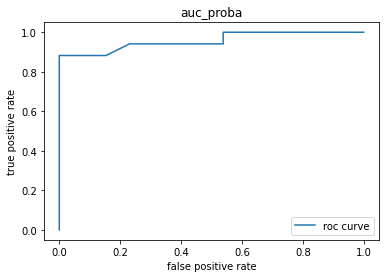

In [28]:
# AUC曲線可視化

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# auc曲線描画のため、y_testの2→1、1→0に変更
condition_0 = y_test % 1 == 0
condition_1 = y_test % 2 == 1

y_test[condition_0] = 0
y_test[condition_1] = 1

print('auc : ', roc_auc_score(y_true=y_test, y_score=proba))

fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=proba)
plt.plot(fpr, tpr, label='roc curve' % auc(fpr, tpr)) # (area = %0.3f)
# plt.plot([0, 1], [0, 1], linestyle='--', label='random')
# plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.title('auc_proba')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

predict : 
 [2 2 2 1 1 1 2 2 1 1 1 1 2 2 2 1 1 2 1 1 2 1 1 1 2 1 1 2 1 2]
predict_proba : 
 [[0.33278539 0.66721461]
 [0.08316366 0.91683634]
 [0.07376988 0.92623012]
 [0.89675215 0.10324785]
 [0.89345284 0.10654716]
 [0.94120845 0.05879155]
 [0.49654703 0.50345297]
 [0.02370521 0.97629479]
 [0.98663901 0.01336099]
 [0.71381354 0.28618646]
 [0.78829029 0.21170971]
 [0.96937896 0.03062104]
 [0.49654703 0.50345297]
 [0.30980362 0.69019638]
 [0.09452856 0.90547144]
 [0.74633746 0.25366254]
 [0.57247287 0.42752713]
 [0.47898875 0.52101125]
 [0.95021017 0.04978983]
 [0.97803015 0.02196985]
 [0.00471494 0.99528506]
 [0.5551905  0.4448095 ]
 [0.62311591 0.37688409]
 [0.94677786 0.05322214]
 [0.38695341 0.61304659]
 [0.86191144 0.13808856]
 [0.80369698 0.19630302]
 [0.41224    0.58776   ]
 [0.9529631  0.0470369 ]
 [0.00347718 0.99652282]]
train score : 
 0.9714285714285714
test score : 
 0.5
混同行列 : 
 [[ 0  2 11]
 [ 0 15  2]
 [ 0  0  0]]
(30,)
(30, 2)


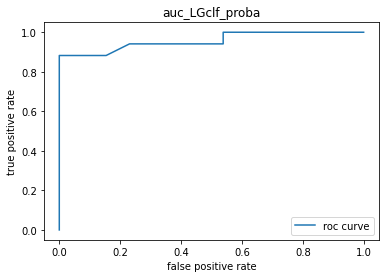

In [36]:
# sklearnnoのロジスティック回帰 
from sklearn.linear_model import LogisticRegression
 
LGclf = LogisticRegression(random_state=0)
LGclf.fit(x_train, y_train)
 
# 学習の結果
LGclf_pred = LGclf.predict(x_test)
LGclf_proba = LGclf.predict_proba(x_test)
print(f'predict : \n {LGclf_pred}')
print(f'predict_proba : \n {LGclf_proba}')
print(f'train score : \n {LGclf.score(x_train, y_train)}')
print(f'test score : \n {LGclf.score(x_test, y_test)}')

# scikit-learnの結果
sklearn_cmatrix = confusion_matrix(y_test,LGclf_pred) 
print(f'混同行列 : \n {sklearn_cmatrix}')
# print(f'正解率 : \n {accuracy_score(y_test,LGclf_pred)}')
# print(f'適合率 : \n {precision_score(y_test,LGclf_pred)}')
# print(f'再現率 : \n {recall_score(y_test,LGclf_pred)}')
# print(f'F1値  :  \n{f1_score(y_test,LGclf_pred)}')

# ACU可視化
# print('auc : ', roc_auc_score(y_true=y_test, y_score=LGclf_proba))
print(y_test.shape)
print(LGclf_proba.shape)
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=LGclf_proba[:,0])
plt.plot(fpr, tpr, label='roc curve' % auc(fpr, tpr)) # (area = %0.3f)
# plt.plot([0, 1], [0, 1], linestyle='--', label='random')
# plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.title('auc_LGclf_proba')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

問題6　学習曲線のプロット

[ 1.02237175 -6.9037169  -6.90443909 ... -7.87240121 -7.8724255
 -7.87244978]
(5001,)
[ 0.         -6.07895912 -6.07969004 ... -7.09836922 -7.09839621
 -7.09842318]
(5001,)


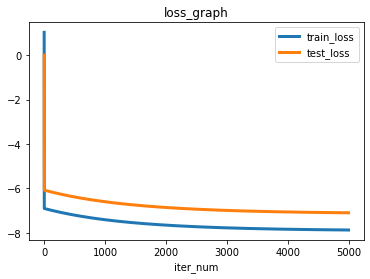

In [29]:
train_loss = MySCR.train_loss #train
print(train_loss)
print(train_loss.shape)
test_loss_list = MySCR.test_loss #test
print(test_loss_list)
print(test_loss_list.shape)

# shapeを調整
train_loss = np.delete(train_loss, 1000, axis=0)
test_loss_list = np.delete(test_loss_list, 1000, axis=0)

# 損失関数について
# 推定結果のグラフ
plt.title('loss_graph')
plt.xlabel('iter_num')
plt.plot(np.arange(MySCR.iter), train_loss, label='train_loss', linewidth="3")
plt.plot(np.arange(MySCR.iter), test_loss_list, label='test_loss',linewidth="3")
plt.legend()
plt.show()


問題7　決定領域の可視化

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.


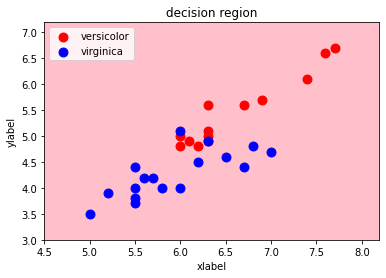

None


In [30]:
print(decision_region(x_test, y_test, MySCR))

# # predict結果
# plt.plot(predict)
# plt.xlabel('Predict_count(test_data_num)')
# plt.ylabel("Species")
# # plt.legend()
# plt.show()

# plt.plot(proba)
# plt.xlabel('Predict_count(test_data_num)')
# plt.ylabel("Species")
# # plt.legend()
# plt.show()